In [1]:
cd /content/drive/MyDrive/Data Mining

/content/drive/MyDrive/Data Mining


In [2]:
!pip install pytrends

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from pytrends import dailydata
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
bitcoin_1_day_data = pd.read_csv('BTC-USDT-1d.csv')

In [5]:
bitcoin_1_day_data.drop(columns = ['quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore','close_time'],inplace=True)
#bitcoin_1_day_data.drop(columns = ["volume","number_of_trades"],inplace=True)

In [6]:
bitcoin_1_day_data.head()

,open_time,open,high,low,close,volume,number_of_trades
0,1502928000000,4261.48,4485.39,4200.74,4285.08,795.150377,3427
1,1503014400000,4285.08,4371.52,3938.77,4108.37,1199.888264,5233
2,1503100800000,4108.37,4184.69,3850.00,4139.98,381.309763,2153
3,1503187200000,4120.98,4211.08,4032.62,4086.29,467.083022,2321
4,1503273600000,4069.13,4119.62,3911.79,4016.00,691.743060,3972


In [7]:
bitcoin_1_day_data['open_time'] = pd.to_datetime(bitcoin_1_day_data['open_time'],unit='ms').astype('str')

In [18]:
bitcoin_1_day_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,1571.0,16864.839064,16919.821554,3188.010000,6709.100000,9231.400000,1.641526e+04,6.752582e+04
high,1571.0,17379.047804,17422.350672,3276.500000,6836.015000,9400.000000,1.715969e+04,6.900000e+04
low,1571.0,16277.967537,16334.396860,2817.000000,6545.305000,9035.000000,1.572236e+04,6.622240e+04
close,1571.0,16892.701222,16935.015374,3189.020000,6712.280000,9232.000000,1.653847e+04,6.752583e+04
volume,1571.0,50599.094700,36573.812596,228.108068,28436.402899,43648.036943,6.503041e+04,4.022017e+05
number_of_trades,1571.0,749228.818587,761051.367406,2153.000000,211014.000000,430359.000000,1.096416e+06,6.331062e+06


In [19]:
google_trends_list = ['bitcoin chart',
 'bitcoin dollar',
 'bitcoin dolar',
 'bitcoin news',
 'bitcoin mining',
 'btc',
 'bitcoin usd',
 'bitcoin',
 'bitcoin to usd',
 'bitcoin price usd',
 'bitcoin stock',
 'bitcoin wallet',
 'bitcoin value',
 'cryptocurrency',
 'coinbase',
 'miner',
 'price bitcoin',
 'sell bitcoin ori',
 'sell bitcoin',
 'sell btc',
 'what is bitcoin']

In [20]:
"""for topic in google_trends_list:
  print(topic)
  dailydata.get_daily_data(topic, 2017, 8, 2021, 12, geo = '').to_csv("google trends data/"+topic+'.csv')"""

'for topic in google_trends_list:\n  print(topic)\n  dailydata.get_daily_data(topic, 2017, 8, 2021, 12, geo = \'\').to_csv("google trends data/"+topic+\'.csv\')'

In [21]:
'''
google_trends_dataframe = pd.DataFrame()
for keyword in os.listdir("google trends data/"):
  if not len(google_trends_dataframe):
    google_trends_dataframe = pd.read_csv("google trends data/"+keyword)[['date',keyword[:-4]]]
  if len(google_trends_dataframe):
    google_trends_dataframe = pd.merge(google_trends_dataframe,pd.read_csv("google trends data/"+keyword)[['date',keyword[:-4]]])
'''
'''
merged_dataframe = bitcoin_1_day_data
'''
google_trends_dataframe = pd.read_csv("google trends data/"+'bitcoin.csv')[['date','bitcoin']]

In [22]:
google_trends_dataframe.dropna(inplace=True)

In [23]:
google_trends_dataframe.head()

,date,bitcoin
5,2017-08-06,7.80
6,2017-08-07,9.75
7,2017-08-08,9.45
8,2017-08-09,9.00
9,2017-08-10,8.85


In [24]:
merged_dataframe = pd.merge(bitcoin_1_day_data,google_trends_dataframe,left_on='open_time',right_on='date')

In [25]:
merged_dataframe.drop(columns=['date'],inplace=True)

In [26]:
merged_dataframe.head()

,open_time,open,high,low,close,volume,number_of_trades,bitcoin
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,3427,16.40
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,5233,16.40
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2153,14.60
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2321,10.24
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,3972,11.04


In [27]:
n = len(merged_dataframe)
training_set = merged_dataframe.iloc[0:int(n*0.7),1:].values
test_set = merged_dataframe.iloc[int(n*0.7):,1:].values

num_features = training_set.shape[1]

In [28]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
print(sc.fit(training_set))
training_set_scaled = sc.transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i,:])
    y_train.append(training_set_scaled[i,3])
X_train, y_train = tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)
print(X_train.shape, y_train.shape)

MinMaxScaler()
(1038, 60, 7) (1038,)


In [29]:
test_set_scaled = sc.transform(test_set)
X_test = []
y_test = []
for i in range(60, len(test_set)):
    X_test.append(test_set_scaled[i-60:i, :])
    y_test.append(test_set_scaled[i,3])
X_test,y_test = tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)

In [30]:
model = Sequential()
model.add(LSTM(units = 120))
model.add(Dropout(0.5))
model.add(Dense(units = 1))

# Compiling the RNN
def compile_and_fit(model, X_train, y_train):
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)
  return history

# Fitting the RNN to the Training set
history = compile_and_fit(model,X_train, y_train)

Epoch 1/100
33/33 [==============================] - 3s 42ms/step - loss: 0.0109
Epoch 2/100
33/33 [==============================] - 1s 42ms/step - loss: 0.0045
Epoch 3/100
33/33 [==============================] - 1s 41ms/step - loss: 0.0038
Epoch 4/100
33/33 [==============================] - 1s 41ms/step - loss: 0.0040
Epoch 5/100
33/33 [==============================] - 1s 39ms/step - loss: 0.0030
Epoch 6/100
33/33 [==============================] - 1s 41ms/step - loss: 0.0029
Epoch 7/100
33/33 [==============================] - 1s 41ms/step - loss: 0.0029
Epoch 8/100
33/33 [==============================] - 1s 41ms/step - loss: 0.0029
Epoch 9/100
33/33 [==============================] - 1s 40ms/step - loss: 0.0027
Epoch 10/100
33/33 [==============================] - 1s 41ms/step - loss: 0.0024
Epoch 11/100
33/33 [==============================] - 1s 42ms/step - loss: 0.0028
Epoch 12/100
33/33 [==============================] - 1s 41ms/step - loss: 0.0026
Epoch 13/100
33/33 [=====

In [31]:
model.save('my_model_with_google_trends')

INFO:tensorflow:Assets written to: my_model_with_google_trends/assets


INFO:tensorflow:Assets written to: my_model_with_google_trends/assets


In [40]:
predicted_stock_price = model.predict(X_test)/sc.scale_[3]

new_model = tf.keras.models.load_model('my_model_without_google_trends')
predicted_stock_price_without_google_trends = new_model.predict(X_test[:,:,:-1])/sc.scale_[3]

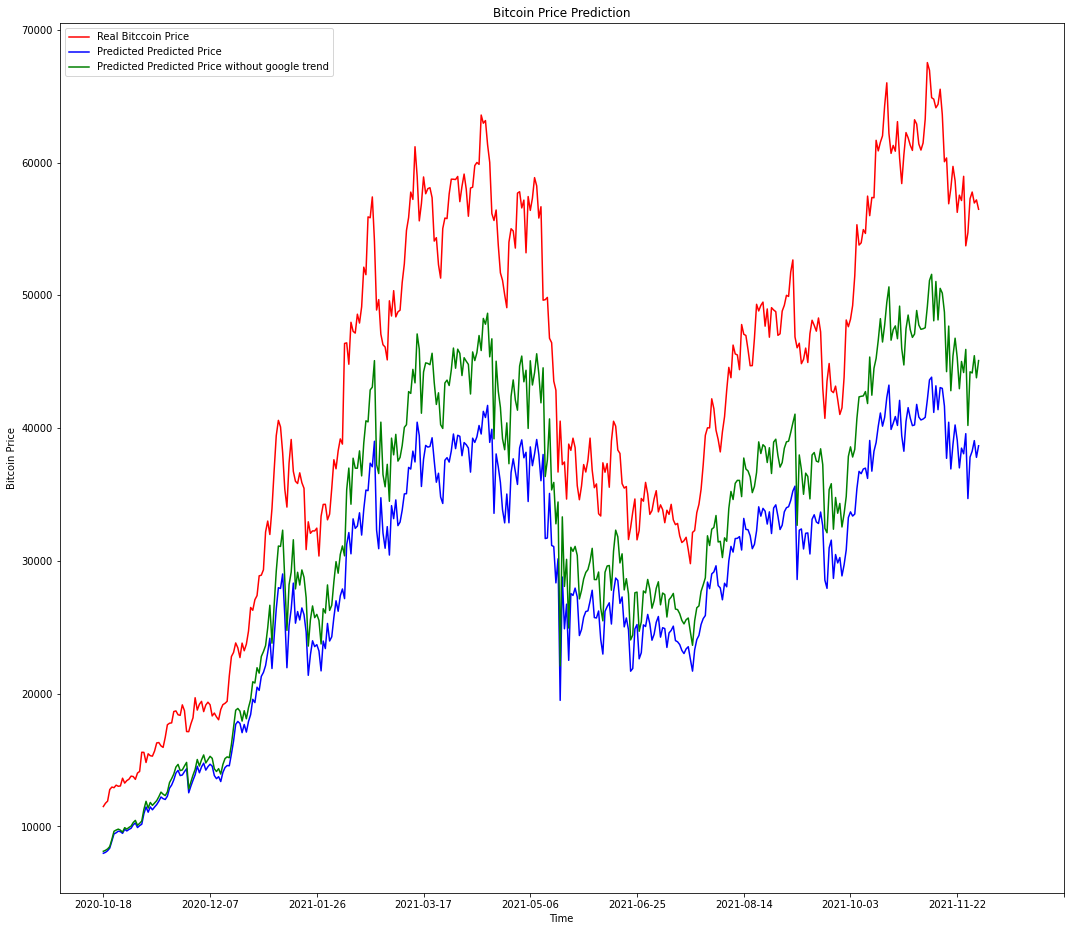

In [42]:
# Visualising the results
plt.figure(figsize=(18,16))
plt.plot(merged_dataframe.loc[int(0.7*n)+60:,"open_time"],test_set[60:,3], color = 'red', label = 'Real Bitccoin Price')
plt.plot(merged_dataframe.loc[int(0.7*n)+60:, "open_time"],predicted_stock_price, color = 'blue', label = 'Predicted Predicted Price')
plt.plot(merged_dataframe.loc[int(0.7*n)+60:, "open_time"],predicted_stock_price_without_google_trends, color = 'green', label = 'Predicted Predicted Price without google trend')

plt.xticks(np.arange(0,461,50))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

In [120]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


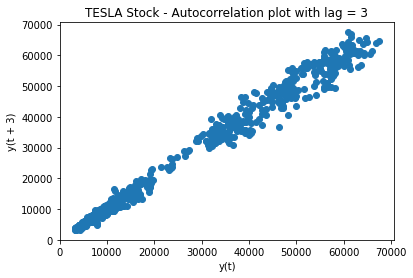

In [122]:
plt.figure()
lag_plot(bitcoin_1_day_data['open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

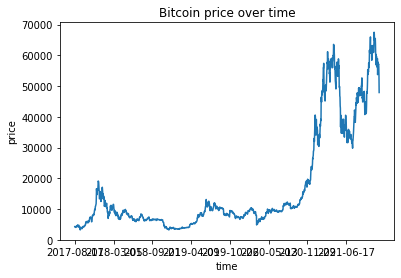

In [124]:
plt.plot(bitcoin_1_day_data["open_time"], bitcoin_1_day_data["close"])
plt.xticks(np.arange(0,len(bitcoin_1_day_data), 200), bitcoin_1_day_data['open_time'][0:len(bitcoin_1_day_data):200])
plt.title("Bitcoin price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [132]:
train_data, test_data = bitcoin_1_day_data[0:int(len(bitcoin_1_day_data)*0.7)], bitcoin_1_day_data[int(len(bitcoin_1_day_data)*0.7):]
training_data = train_data['close'].values
test_data = test_data['close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(maxiter=200,disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing Mean Squared Error is 2894358.868903744


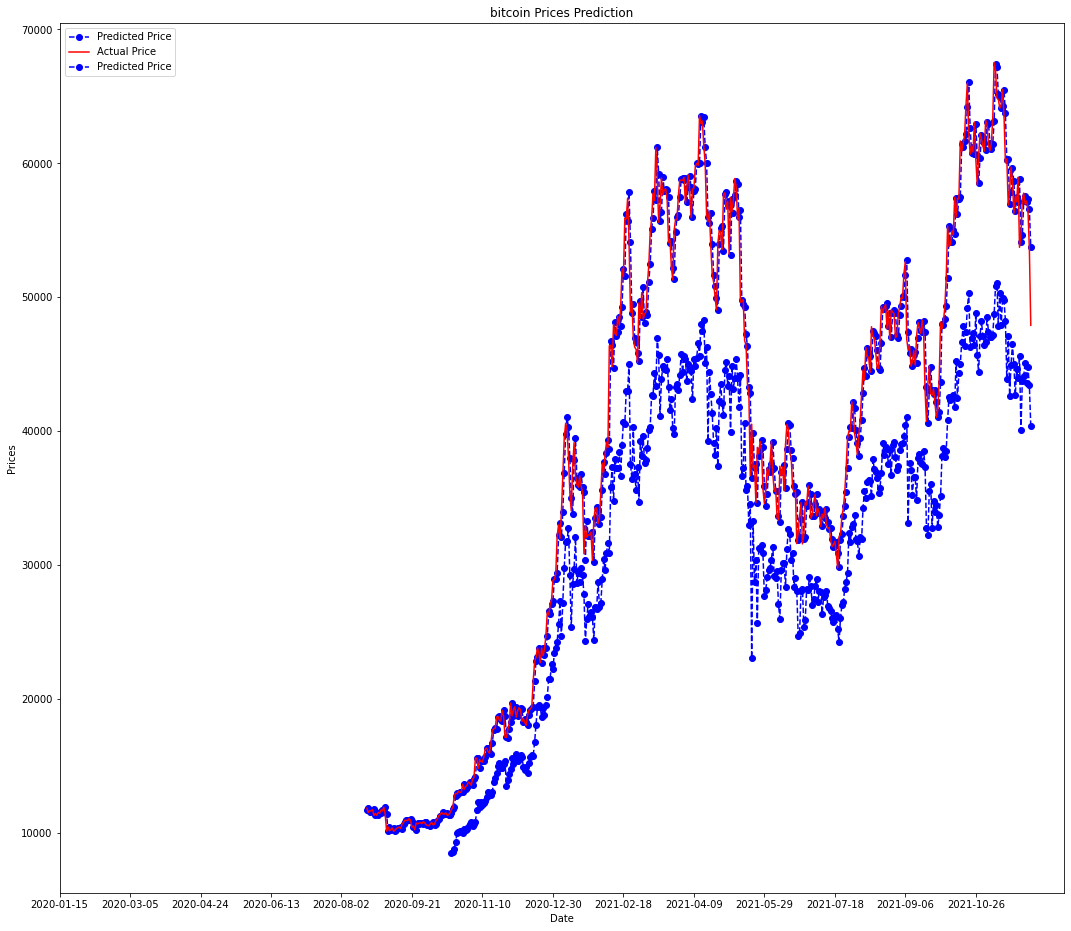

In [188]:
test_set_range = bitcoin_1_day_data[int(len(bitcoin_1_day_data)*0.7):].index
plt.figure(figsize=(18,16))
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.plot(test_set_range[60:], predicted_stock_price, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.title('bitcoin Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(881,len(bitcoin_1_day_data),50), bitcoin_1_day_data.open_time[881:len(bitcoin_1_day_data):50])
plt.legend()
plt.show()